In [9]:
import numpy as np
from scipy.integrate import solve_ivp
from SALib.sample import saltelli, sobol, fast_sampler
from SALib.analyze import sobol, fast
import seaborn as sns
import matplotlib.pyplot as plt
import math
import SALib
from scipy.optimize import fsolve
from scipy.constants import N_A

In [10]:
Target_cell_number = 2e5
well_size = 150e-6
r_ab = 1.25e-6 # in cm
t_end = 60*60*100000000
t = np.geomspace(1e-10, t_end, 20)
tspan = [1e-10, t_end]
z0 = [0, 0, 0]
z01 = [0, 0]
T_cell_radius = 5e-4 #cm
T_cell_surface_area = 4*math.pi*((T_cell_radius)**2)
tumour_cell_radius = 8e-6
tumour_cell_surface_area = 4*math.pi*((tumour_cell_radius)**2)

In [11]:
sigma = well_size*N_A/Target_cell_number

def A1_steady_state(x, Ainit, k1, koff, k2, rtot, dummy):
    k1 = k1/sigma
    Atot = sigma*Ainit
    express = 2*k1*(rtot - x - 2*(k2*x*(rtot-x)/(2*(koff + k2*x))))*(Atot - x - (k2*x*(rtot-x)/(2*(koff + k2*x)))) -koff*x - k2*x*(rtot - x - 2*(k2*x*(rtot-x)/(2*(koff + k2*x)))) +2*koff*(k2*x*(rtot-x)/(2*(koff + k2*x)))

    return express

def A2_steady_state(x, k2, koff, rtot, dummy):
    express = k2*x*(rtot-x)/(2*(koff + k2*x))

    return express

problem1 = {
    'num_vars': 5,
    'names': ['rtot', 'kon', 'r_ab', 'koff', 'dummy'],
    'bounds': [[4, 6],
               [4, 6],
               [1e-8, 5e-8],
               [-6, -4],
               [1, 1000]]
}

In [12]:
vals = SALib.sample.sobol.sample(problem1, 65536)
Y_ag1 = np.zeros(len(vals))
Y_ag2 = np.zeros(len(vals))
Y_ab = np.zeros(len(vals))
indicies_ag1 = []
indicies_ag2 = []
indicies_ab = []
A0s = [1e-11, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5]

Y = np.zeros(len(vals))
indicies = []
indicies_1 = []

In [13]:
16384*16

262144

In [14]:
for Ainit in A0s:
    print(Ainit)
    for i, params in enumerate(vals):
      
        rtot = params[0]
        rtot = 10**rtot
        kon = params[1]
        kon = 10**kon
        r_ab = params[2]
        koff = params[3]
        koff = 10**koff
        dummy = params[4]

        reaction_volume = (2*1e3*math.pi*(r_ab**3))/3
        target_effective_conc =(rtot)*((math.pi*(r_ab**2))/(tumour_cell_surface_area))*(1/N_A)/(reaction_volume)
        k2 = target_effective_conc*kon/rtot  
        
        if Ainit < 1e-8:
            guess = 0
        else:
            guess = 0

        A1_st = fsolve(A1_steady_state, [guess], args=(Ainit, kon, koff, k2, rtot, dummy))
        A2_st = A2_steady_state(A1_st, k2, koff, rtot, dummy)
        if (A1_st < 0) or (A2_st < 0) :
            print('negative')
        
        if ((A1_st + 2*A2_st) > rtot):
            print('blown up')
        Ag = (A1_st + 2*A2_st)/rtot
        Y[i] = Ag
    
    Si = sobol.analyze(problem1, Y, print_to_console=True)
    indicies.append(Si['ST'])
    indicies_1.append(Si['S1'])


1e-11
             ST   ST_conf
rtot   0.996248  0.008320
kon    0.014376  0.000894
r_ab   0.000681  0.000055
koff   0.014348  0.000960
dummy  0.000000  0.000000
             S1   S1_conf
rtot   0.978540  0.012471
kon    0.001078  0.001171
r_ab   0.000037  0.000288
koff   0.001056  0.001173
dummy  0.000000  0.000000
                     S2   S2_conf
(rtot, kon)    0.005680  0.020265
(rtot, r_ab)   0.000116  0.020201
(rtot, koff)   0.005715  0.020022
(rtot, dummy) -0.000026  0.020196
(kon, r_ab)    0.000138  0.001877
(kon, koff)    0.001426  0.001758
(kon, dummy)   0.000067  0.001878
(r_ab, koff)   0.000015  0.000448
(r_ab, dummy) -0.000028  0.000468
(koff, dummy)  0.000175  0.001713
1e-10
             ST   ST_conf
rtot   0.995642  0.007272
kon    0.005514  0.000240
r_ab   0.000316  0.000020
koff   0.005515  0.000241
dummy  0.000000  0.000000
             S1   S1_conf
rtot   0.991810  0.008140
kon    0.001308  0.000824
r_ab   0.000031  0.000184
koff   0.001313  0.000635
dummy  0.000000 

/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


             ST   ST_conf
rtot   0.523265  0.015467
kon    0.412470  0.019064
r_ab   0.027064  0.001892
koff   0.412824  0.016689
dummy  0.000000  0.000000
             S1   S1_conf
rtot   0.402428  0.021328
kon    0.135068  0.009747
r_ab   0.004051  0.001873
koff   0.136540  0.008406
dummy  0.000000  0.000000
                     S2   S2_conf
(rtot, kon)    0.037959  0.030819
(rtot, r_ab)   0.000680  0.031354
(rtot, koff)   0.035618  0.033747
(rtot, dummy) -0.000300  0.031311
(kon, r_ab)    0.009661  0.014768
(kon, koff)    0.182747  0.022499
(kon, dummy)   0.003952  0.014064
(r_ab, koff)   0.005867  0.003992
(r_ab, dummy)  0.000367  0.003330
(koff, dummy)  0.002014  0.012646
1e-08


/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


             ST   ST_conf
rtot   0.309444  0.015633
kon    0.655903  0.030249
r_ab   0.042085  0.003221
koff   0.656566  0.028936
dummy  0.000000  0.000000
             S1   S1_conf
rtot   0.055015  0.006885
kon    0.197197  0.013449
r_ab   0.005844  0.002408
koff   0.197037  0.014118
dummy  0.000000  0.000000
                     S2   S2_conf
(rtot, kon)    0.073390  0.019893
(rtot, r_ab)   0.000739  0.012492
(rtot, koff)   0.072206  0.019863
(rtot, dummy) -0.000994  0.012212
(kon, r_ab)    0.011944  0.023964
(kon, koff)    0.265396  0.038910
(kon, dummy)   0.003732  0.022931
(r_ab, koff)   0.007740  0.006109
(r_ab, dummy) -0.000063  0.004487
(koff, dummy)  0.002912  0.022792
1e-07


/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


             ST   ST_conf
rtot   0.286840  0.016577
kon    0.660439  0.030965
r_ab   0.035870  0.002497
koff   0.661135  0.027934
dummy  0.000000  0.000000
             S1   S1_conf
rtot   0.051028  0.006137
kon    0.204496  0.013272
r_ab   0.005209  0.002586
koff   0.204379  0.012746
dummy  0.000000  0.000000
                     S2   S2_conf
(rtot, kon)    0.068294  0.015197
(rtot, r_ab)   0.000067  0.009847
(rtot, koff)   0.067214  0.018567
(rtot, dummy) -0.001119  0.009924
(kon, r_ab)    0.010829  0.023159
(kon, koff)    0.276484  0.035946
(kon, dummy)   0.003517  0.022262
(r_ab, koff)   0.006992  0.006074
(r_ab, dummy) -0.000030  0.004780
(koff, dummy)  0.002547  0.022275
1e-06


/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


             ST   ST_conf
rtot   0.209173  0.010130
kon    0.671822  0.025622
r_ab   0.021904  0.001446
koff   0.672461  0.030424
dummy  0.000000  0.000000
             S1   S1_conf
rtot   0.038007  0.004221
kon    0.230193  0.013338
r_ab   0.003643  0.001816
koff   0.230192  0.012691
dummy  0.000000  0.000000
                     S2   S2_conf
(rtot, kon)    0.050271  0.012081
(rtot, r_ab)  -0.001070  0.007546
(rtot, koff)   0.049620  0.012724
(rtot, dummy) -0.001312  0.007399
(kon, r_ab)    0.007552  0.021486
(kon, koff)    0.310751  0.038592
(kon, dummy)   0.002556  0.021165
(r_ab, koff)   0.004990  0.004470
(r_ab, dummy)  0.000046  0.003465
(koff, dummy)  0.001379  0.018777
1e-05
             ST   ST_conf
rtot   0.082327  0.004178
kon    0.689743  0.019487
r_ab   0.008522  0.000532
koff   0.690273  0.023663
dummy  0.000000  0.000000
             S1   S1_conf
rtot   0.015239  0.002582
kon    0.271648  0.011600
r_ab   0.001432  0.000851
koff   0.271824  0.013508
dummy  0.000000  0.000

/var/folders/fj/3c6fc0c93lg7p91tnylb8zj80000gn/T/ipykernel_46529/952455350.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('Dark2')
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


7


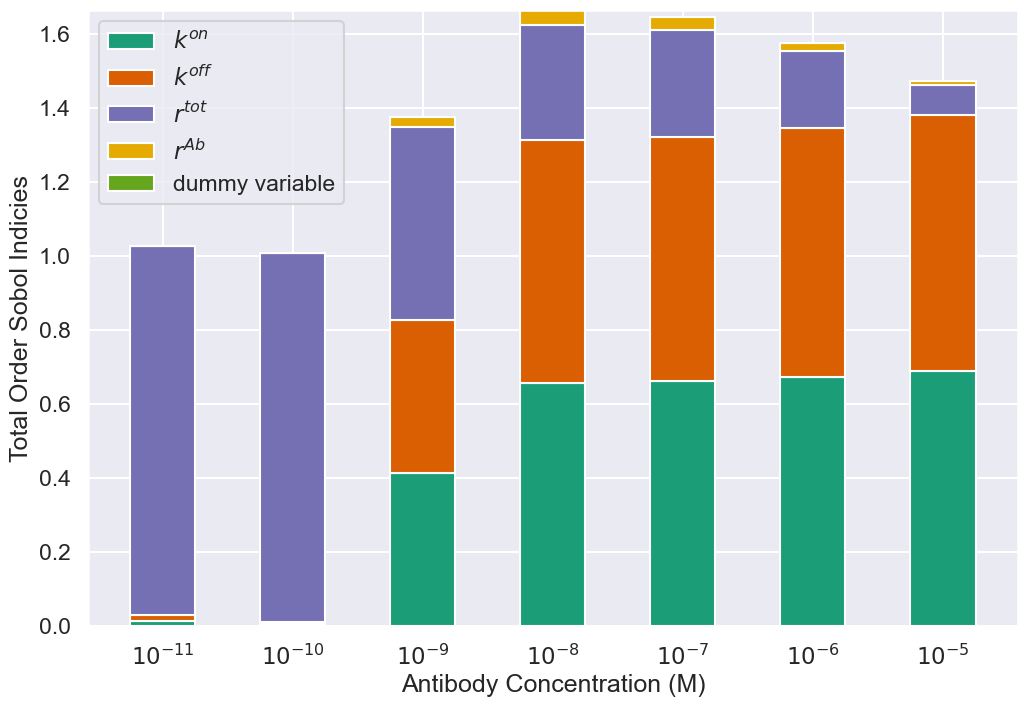

In [15]:

kon_si = np.zeros(len(A0s))
koff_si = np.zeros(len(A0s))
rab_si = np.zeros(len(A0s))
rtot_si = np.zeros(len(A0s))
dummy_si = np.zeros(len(A0s))


for i in range(len(indicies)):
    vals = indicies[i]
    rtot_si[i] = vals[0]
    kon_si[i] = vals[1]
    rab_si[i] = vals[2]
    koff_si[i] = vals[3]
    dummy_si[i] = vals[4]

print(len(indicies))
ab_conc = ( r'$10^{-11}$', r'$10^{-10}$', r'$10^{-9}$', r'$10^{-8}$', r'$10^{-7}$', r'$10^{-6}$', r'$10^{-5}$')


sns.set_theme()
sns.set_context("talk")

width = 0.5
fig, ax = plt.subplots(figsize=(12,8))
bottom = np.zeros(7)

cm = plt.cm.get_cmap('Dark2')
ax.bar(ab_conc, kon_si, width, label=r'$k^{on}$', bottom= bottom, color=cm(0))
bottom+= kon_si
ax.bar(ab_conc, koff_si, width, label=r'$k^{off}$', bottom= bottom, color=cm(1))
bottom+= koff_si
ax.bar(ab_conc, rtot_si, width, label=r'$r^{tot}$', bottom= bottom, color=cm(2))
bottom+= rtot_si
ax.bar(ab_conc, rab_si, width, label=r'$r^{Ab}$', bottom= bottom, color=cm(5))
bottom+= rab_si
ax.bar(ab_conc, dummy_si, width, label='dummy variable', bottom=bottom, color=cm(4))
ax.legend(loc='best')
ax.set_xlabel('Antibody Concentration (M)')
ax.set_ylabel('Total Order Sobol Indicies')
plt.savefig('/Users/lukeheirene/ADCC-Project/Figures/model_r_receptor_occupancy_total_order_sensiv_analysis.eps')

In [16]:
3*1e6/(8*N_A*1e3*1e-15)

6.227021501901925e-07